# LAVD_days function

In this notebook I want to make a function for RCLV_atlas that takes trajectories and calculates LAVD for a sub-time of the trajectories. For example, if the trajectories are 16days then I can calculate LAVD from 0-16days by just inputting the trajectories and LAVD days.

Current to do:

6. make RCLV id function take in my new fields
7. identify RCLVs on 0 day thing

### updates:

currently mean lavd is increasing with longer delta t. check if it is the case in the original lavd fields

In the original LAVD fields the mean values are the same for 8 day and 32 day. so smth wron with the integration

the mean lavd value is correct for day0, but not for all other days

In [ ]:
import os,sys
import trajan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from config import *

sys.path.append('./RCLVatlas')
from subfunctions_for_RCLV_atlas import read_RCLV_CSV_untracked,read_RCLV_CSV_tracked,save_RCLV_CSV
from mainfunctions_for_RCLV_atlas import *
from functions_for_parcels import *
from scipy import integrate



In [2]:
traj_path= "/scratch/b/b382618/32day/lang_traj/20100525_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr"

## Original LAVD function for full 8day trajectories

In [16]:
def calc_LAVD(vort,output_freq,runtime):
    vort_avg_t = np.nanmean(vort,axis=0)[1:] #Find average vorticity over the entire spatial domain at each time step
    LAVD = np.trapz(np.absolute(vort[:,1:] - vort_avg_t), dx=output_freq*60*60, axis=1)/(runtime*24*60*60-output_freq*60*60) #trapz does the integration; convert data to be in seconds units
    return LAVD

In [17]:
origianl_traj_path= '/work/bk1377/b382618/RCLVs/8day/lang_traj/20100525_8days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr'

In [18]:
save_to_path= "/scratch/b/b382618/test_LAVD_days_function/"

This uses the original calculate_LAVD function

In [19]:
def trajectories_to_all_day_LAVD(traj_path):
    print("Calculating the LAVD ...")
    traj_ds = xr.open_dataset(traj_path) # open the Lagrangian trajectory dataset that was just produced
    vort_premask = traj_ds.variables["vort"]
    vort = np.array(vort_premask.where(vort_premask != 0)) #filters out land values
    LAVD = calc_LAVD(vort,sim_params['output_freq'],sim_params['runtime'])
    LAVD_output_file_path = save_to_path + '8day_LAVD.npy'
    np.save(LAVD_output_file_path,LAVD)
    print('LAVD output file: %s'%(LAVD_output_file_path))

In [20]:
trajectories_to_all_day_LAVD(origianl_traj_path)

Calculating the LAVD ...


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tmp/ipykernel_1687195/1879773220.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  LAVD = np.trapz(np.absolute(vort[:,1:] - vort_avg_t), dx=output_freq*60*60, axis=1)/(runtime*24*60*60-output_freq*60*60) #trapz does the integration; convert data to be in seconds units


LAVD output file: /scratch/b/b382618/test_LAVD_days_function/8day_LAVD.npy


2.2058759586209346e-06 4.4615685956986436e-05 6.970863043663258e-08


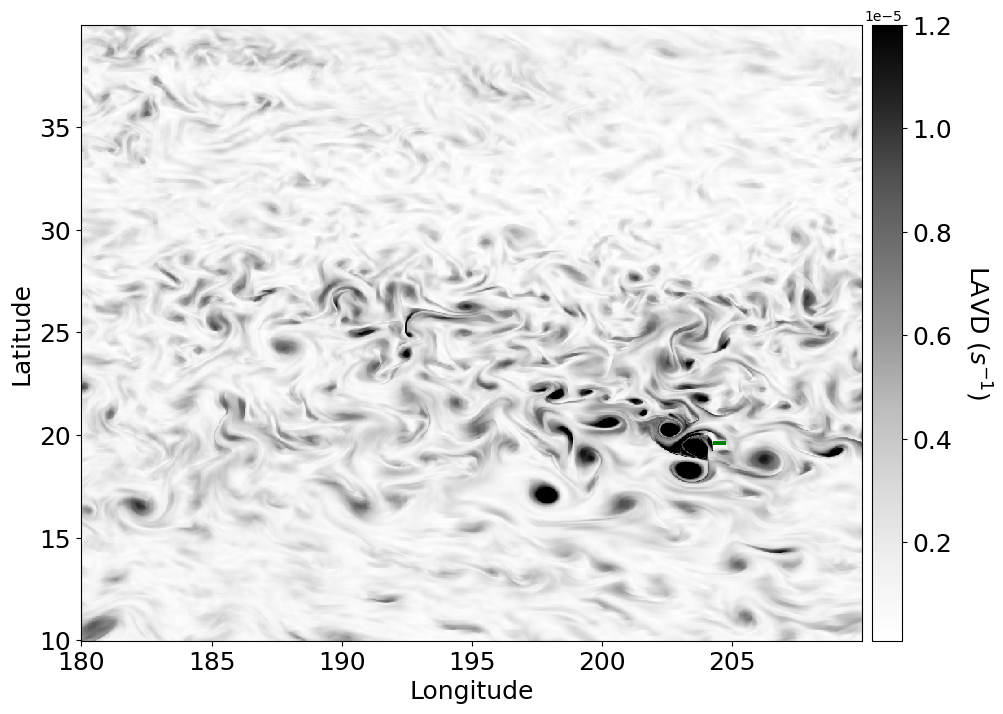

In [21]:
lavd='/scratch/b/b382618/test_LAVD_days_function/8day_LAVD.npy'

# LAVD_output_file_path = LAVD_dir + date + '_LAVD_' + filename_str + '.npy'
LAVD = np.load(lavd)
LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
print(LAVD.mean(),LAVD.max(), LAVD.min())
fontsize = 18

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.set_facecolor("g")
plot = ax.pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));

cbar = plt.colorbar(plot, pad = 0.01)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('LAVD $(s^{-1})$', rotation=270, fontsize=fontsize)
    
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.set_title('%s-%s-%s LAVD'%(date_list[0][4:6],date_list[0][6:8],date_list[0][0:4]),fontsize=24)

plt.show()


## LAVD_days function (original -ish)

In [3]:
def calc_LAVD_spec_time(vort,output_freq,runtime, LAVD_days):
    time_select=LAVD_days*output_freq
    vort_avg_t = np.nanmean(vort,axis=0)[0:] #Find average vorticity over the entire spatial domain at each time step
    
    if LAVD_days==0:
        LAVD = np.absolute(vort[:,0]-vort_avg_t[0]) #this is just vorticity field
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(time_select*6*60*60-output_freq*60*60) #trapz does the integration; convert data to be in se
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1) #trapz does the integration; convert data to be in se

    else:
        LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(LAVD_days*24*60*60-output_freq*60*60) #trapz does the integration; convert data to be in se
    return LAVD


In [64]:
# traj_ds = xr.open_dataset(origianl_traj_path) # open the Lagrangian trajectory dataset that was just produced
# vort_premask = traj_ds.variables["vort"]
# vort = np.array(vort_premask.where(vort_premask != 0)) #filters out land values
# vort_avg_t = np.nanmean(vort,axis=0)[0:] #Find average vorticity over the entire spatial domain at each time step
# time_select=LAVD_days*output_freq
# LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(runtime*24*60*60-output_freq*60*60) #trapz does the integration; convert data to be in se


In [4]:
traj_path

'/scratch/b/b382618/32day/lang_traj/20100525_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr'

In [8]:
base_path = "/scratch/b/b382618/32day/"


In [9]:
def trajectories_to_specific_day_LAVD(traj_path, LAVD_days):
    print("Calculating the LAVD ...")
    traj_ds = xr.open_dataset(traj_path) # open the Lagrangian trajectory dataset that was just produced
    date = str(traj_ds.time.values[0][0])[0:10]
    vort_premask = traj_ds.variables["vort"]
    vort = np.array(vort_premask.where(vort_premask != 0)) #filters out land values
    LAVD = calc_LAVD_spec_time(vort,sim_params['output_freq'],sim_params['runtime'], LAVD_days)
    LAVD_output_file_path = base_path + 'LAVD/sub_days/' + date + "_" +str(LAVD_days) + 'days.npy'
    np.save(LAVD_output_file_path,LAVD)
    print('LAVD output file: %s'%(LAVD_output_file_path))

In [10]:
trajectories_to_specific_day_LAVD(traj_path,1)

Calculating the LAVD ...


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


LAVD output file: /scratch/b/b382618/32day/LAVD/sub_days/2010-05-25_1days.npy


0.0 0.0 0.0


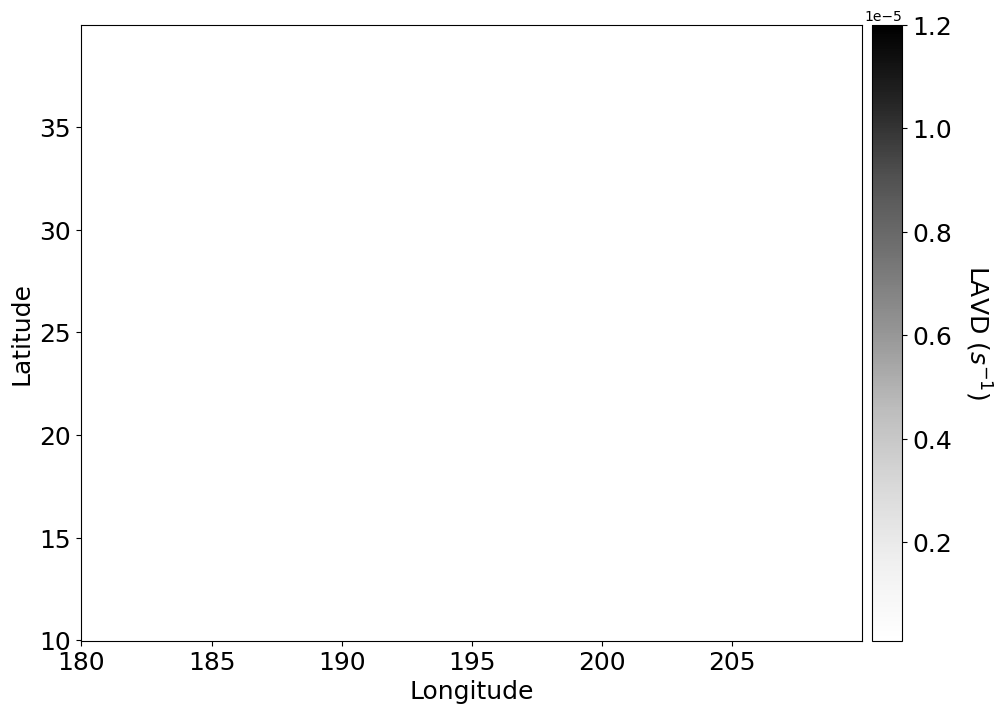

In [13]:
##change this
lavd='/scratch/b/b382618/32day/LAVD/sub_days/2010-05-25_1days.npy'

# LAVD_output_file_path = LAVD_dir + date + '_LAVD_' + filename_str + '.npy'
LAVD = np.load(lavd)
LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
print(LAVD.mean(),LAVD.max(), LAVD.min())
fontsize = 18

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.set_facecolor("g")
plot = ax.pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));

cbar = plt.colorbar(plot, pad = 0.01)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('LAVD $(s^{-1})$', rotation=270, fontsize=fontsize)
    
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.set_title('%s-%s-%s LAVD'%(date_list[0][4:6],date_list[0][6:8],date_list[0][0:4]),fontsize=24)

plt.show()


07.10.2024- ok, now it all works.
Ask lexi why she did not take the 1st time step when selecting.



Still need to make nice saving function!!!

08.10.2024- ok, if I do day 0 LAVD field then it is very pixelated because the base data is 0.25ged. Therefore, to actually compare results I will need small regridded data.


## with cumtrapz function 

###     # Timestep to get initial vorticity needs to be day 1 since at day 0 all particles are initialized with vort=0



In [3]:
# this is the real function, pls don't delete it
def calc_LAVD_spec_time(vort,output_freq,runtime, LAVD_days):
    time_select=int(LAVD_days*(24/output_freq))
    vort_avg_t = np.nanmean(vort,axis=0)[0:] #Find average vorticity over the entire spatial domain at each time step
    
    if LAVD_days==0:
        LAVD = np.absolute(vort[:,0]-vort_avg_t[0]) #this is just vorticity field
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(time_select*6*60*60-output_freq*60*60) #trapz does the integration; convert data to be in se
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1) #trapz does the integration; convert data to be in se

    else:
        # LAVD = integrate.cumulative_trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(LAVD_days*24*60*60-output_freq*60*60)
        ### if i do the above then the values at 0 are small and correct at the end.
        LVD = integrate.cumulative_trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)   
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(LAVD_days*24*60*60-output_freq*60*60) #trapz does the integration; convert data to be in se
    return LVD, time_select


I now have a millions x time steps numpy array. I need to divide each time step by a specific number array to get the right average

divide_by = (i*output_freq*24*60*60-output_freq*60*60)

In [6]:
# LAVD_days = 3 
# output_freq = 6
# time_select=LAVD_days*output_freq


In [7]:
# divide_by_list = []
# for i in np.arange(1, time_select):
#     val = (i*output_freq*24*60*60-output_freq*60*60)
#     divide_by_list.append(val)

## .npy output

In [8]:
base_path = "/scratch/b/b382618/32day/"


In [10]:
def trajectories_to_specific_day_LAVD(traj_path, LAVD_days):
    print("Calculating the LAVD ...")
    traj_ds = xr.open_dataset(traj_path) # open the Lagrangian trajectory dataset that was just produced
    date = str(traj_ds.time.values[0][0])[0:10]
    vort_premask = traj_ds.variables["vort"]
    vort = np.array(vort_premask.where(vort_premask != 0)) #filters out land values
    LVD, time_select = calc_LAVD_spec_time(vort,sim_params['output_freq'],sim_params['runtime'], LAVD_days) # LVD not averaged per time


    # this 
    divide_by_list = []
    for i in np.arange(2, time_select+1):
        val = (i*sim_params['output_freq']*60*60-sim_params['output_freq']*60*60)
        divide_by_list.append(val)
    print(divide_by_list)
    
    LAVD = LVD/divide_by_list
    LAVD_output_file_path = base_path + 'LAVD/sub_days/' + date + "_" +str(LAVD_days) + 'days.npy'
    np.save(LAVD_output_file_path,LAVD)
    print('LAVD output file: %s'%(LAVD_output_file_path))
    return LAVD_output_file_path

In [57]:
LAVD_subtime_path = trajectories_to_specific_day_LAVD(traj_path, 3)

Calculating the LAVD ...


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


[np.int64(21600), np.int64(43200), np.int64(64800), np.int64(86400), np.int64(108000), np.int64(129600), np.int64(151200), np.int64(172800), np.int64(194400), np.int64(216000), np.int64(237600), np.int64(259200), np.int64(280800), np.int64(302400), np.int64(324000), np.int64(345600), np.int64(367200)]
LAVD output file: /scratch/b/b382618/32day/LAVD/sub_days/2010-05-25_3days.npy


In [58]:
path = "/scratch/b/b382618/32day/LAVD/sub_days/2010-05-25_3days.npy"

In [59]:
data = np.load(LAVD_subtime_path)


In [60]:
np.nanmean(data[:,0])

np.float64(2.3006050609908598e-06)

In [61]:
np.nanmean(data[:,16])

np.float64(2.2785967411266984e-06)

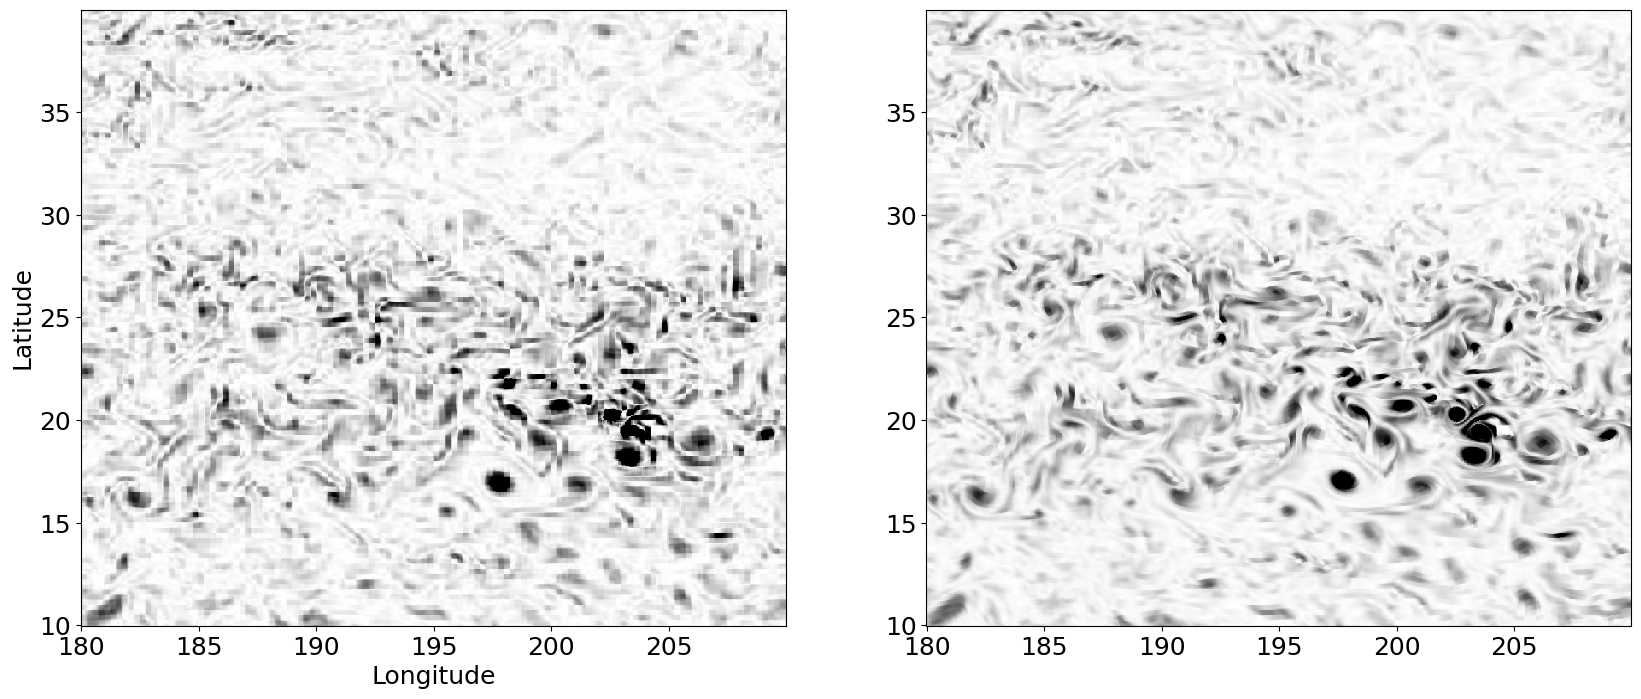

In [62]:
fontsize = 18
fig,ax = plt.subplots(1,2,figsize=(20,8))

ax[0].set_xlabel('Longitude',fontsize=fontsize)
ax[0].set_ylabel('Latitude',fontsize=fontsize)


# Load the LAVD data
LAVD = np.load(path)
LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
LAVD_reshape = np.transpose(np.reshape(LAVD[:,0],(len(traj_lon_array),len(traj_lat_array))))

# Plot the LAVD 
plot = ax[0].pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[0].set_title('',fontsize=24)


LAVD = np.load(path)
LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
LAVD_reshape = np.transpose(np.reshape(LAVD[:,10],(len(traj_lon_array),len(traj_lat_array))))

# Plot the LAVD 
plot = ax[1].pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1].set_title('',fontsize=24)

plt.show()

So is the divide by indexing correct??? the fields look fine

## save it into a .nc file

In [4]:
def trajectories_to_specific_day_LAVD(traj_path, LAVD_days):
    print("Calculating the LAVD ...")
    traj_ds = xr.open_dataset(traj_path) # open the Lagrangian trajectory dataset that was just produced
    date = str(traj_ds.time.values[0][0])[0:10]
    vort_premask = traj_ds.variables["vort"]
    vort = np.array(vort_premask.where(vort_premask != 0)) #filters out land values
    LVD, time_select = calc_LAVD_spec_time(vort,sim_params['output_freq'],sim_params['runtime'], LAVD_days)


    # z=sim_params['output_freq']*60*60
    divide_by_list = []
    for i in np.arange(2, time_select+1):
        val = (i*sim_params['output_freq']*60*60-sim_params['output_freq']*60*60)
        divide_by_list.append(val)
    LAVD = LVD/divide_by_list

    # Create an xarray Dataset with the necessary dimensions
    one_lat = np.unique(traj_ds.lat[:,0])
    one_lon = np.unique(traj_ds.lon[:,0])
    time = traj_ds.time[1:time_select]

    # Check the shape of LAVD and reshape it
    print("Original LAVD shape:", LAVD.shape)
    
    # Reshape LAVD from (921600, 17) to (17, 960, 960)
    num_lat = len(one_lat)
    num_lon = len(one_lon)
    num_time = len(time)
    
    if LAVD.shape == (num_lat * num_lon, num_time):
        LAVD = np.reshape(LAVD, (num_lon, num_lat, num_time))
    else:
        raise ValueError(f"Unexpected LAVD shape {LAVD.shape}. Cannot reshape.")

    print("Reshaped LAVD shape:", LAVD.shape)

    
    LAVD_ds = xr.Dataset(
        {
            'LAVD': (['longitude', 'latitude', 'time'], LAVD)
        },
        coords={
            'time': time,
            'latitude': one_lat,
            'longitude': one_lon
        }
    )

    date_good=str(date.replace("-", ""))
    output_file_name = str(date_good) + "_" + str(LAVD_days) + "days_LAVD.nc"
    # Save the dataset as a NetCDF file
    LAVD_output_file_path = os.path.join(base_path, 'LAVD', output_file_name)
    LAVD_ds.to_netcdf(LAVD_output_file_path)
    
    print('LAVD NetCDF output file: %s' % (LAVD_output_file_path))
    return LAVD_output_file_path


In [5]:
out_p = trajectories_to_specific_day_LAVD(traj_path, 32)

Calculating the LAVD ...


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


Original LAVD shape: (921600, 127)
Reshaped LAVD shape: (960, 960, 127)


NameError: name 'base_path' is not defined

In [6]:
res_path = "/scratch/b/b382618/32day/LAVD/20100525_32days_LAVD.nc"

In [7]:
lavdnc = xr.open_dataset(res_path)

In [8]:
lavdnc

<xarray.Dataset> Size: 936MB
Dimensions:     (longitude: 960, latitude: 960, time: 127, obs: 128,
                 trajectory: 127)
Coordinates:
  * obs         (obs) int32 512B 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * trajectory  (trajectory) int64 1kB 1 2 3 4 5 6 7 ... 122 123 124 125 126 127
    time        (trajectory, obs) datetime64[ns] 130kB ...
  * latitude    (latitude) float32 4kB 10.0 10.03 10.06 ... 39.91 39.94 39.97
  * longitude   (longitude) float32 4kB 180.0 180.0 180.1 ... 209.9 209.9 210.0
Data variables:
    LAVD        (longitude, latitude, time) float64 936MB ...

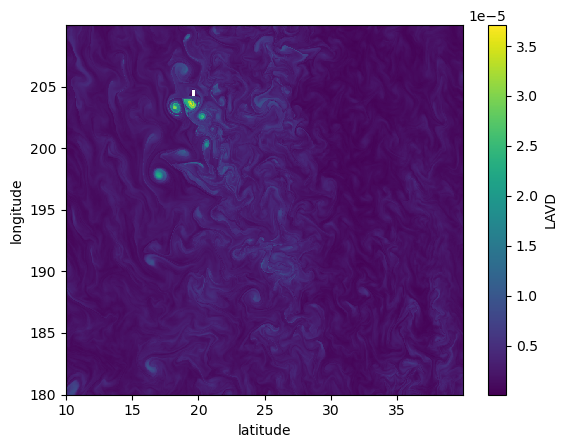

In [9]:
onelavd=lavdnc.LAVD.isel(time = 126)
onelavd.shape
onelavd.plot()

### slay, malacis, it works !!

what to do next:
3. make rclv identify function take in .nc file instead of what it does now

## LAVD plotting function


In [26]:
nc_file_path = "/scratch/b/b382618/32day/LAVD/20100525_32days_LAVD.nc"

In [12]:
dataset = xr.open_dataset(nc_file_path)
LAVD = dataset['LAVD'].values

960

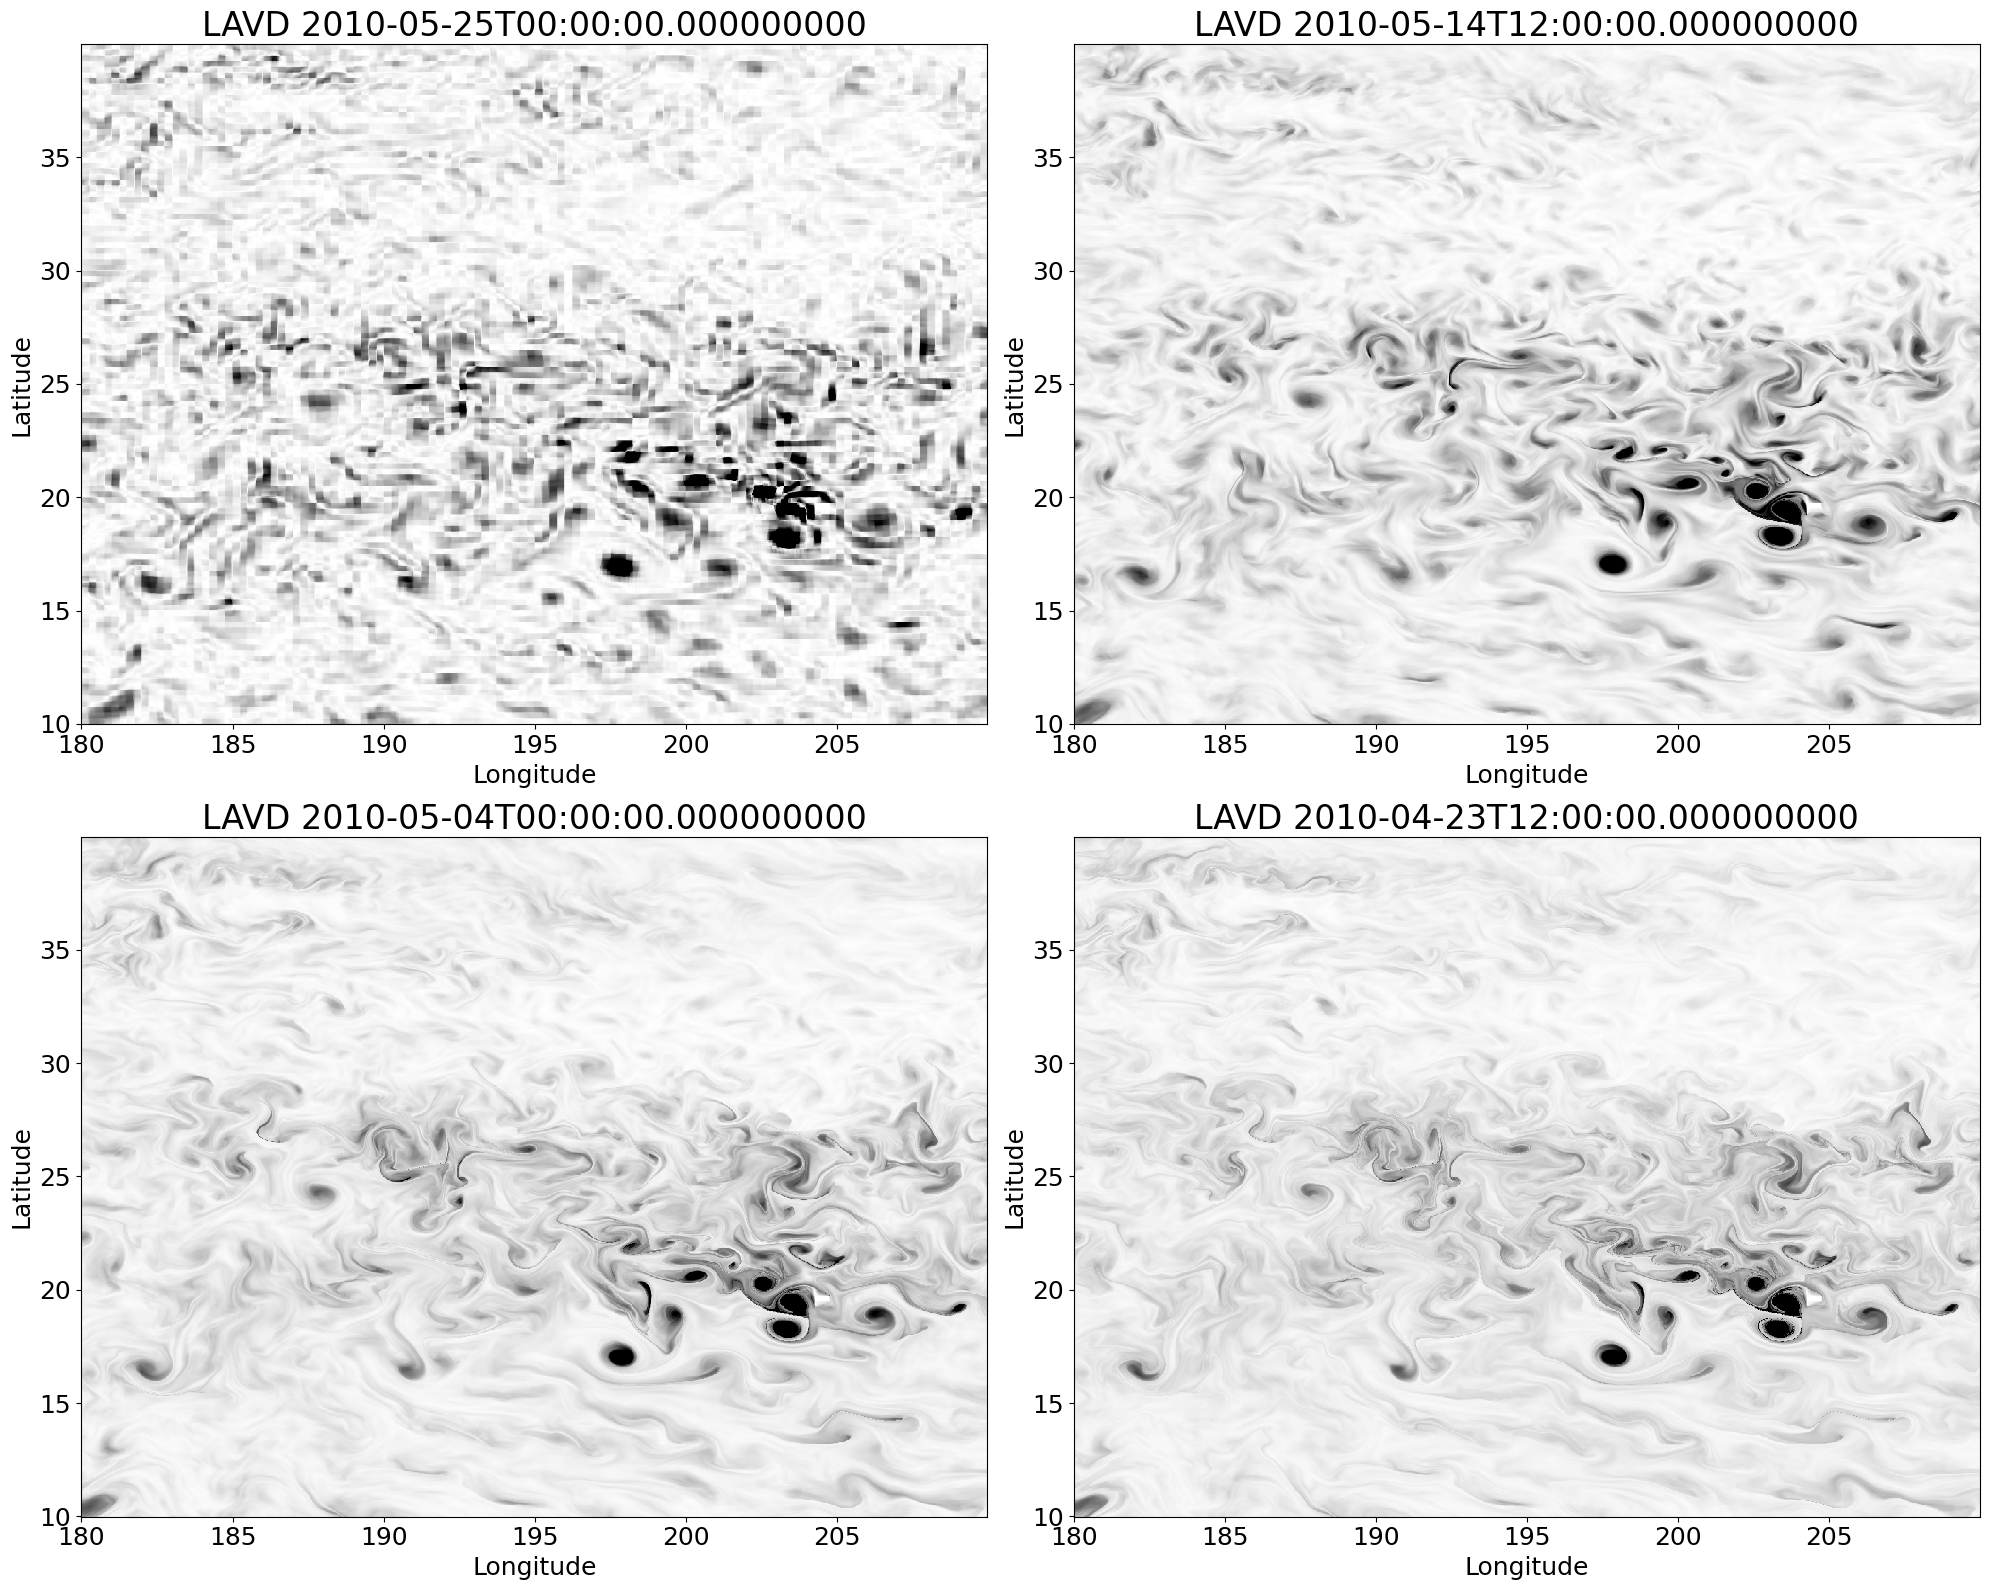

In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def plot_lavd_grid_nc(nc_file_path, lavd_var_name, lon_var_name, lat_var_name, time_var_name, fontsize=18):
    # Open the NetCDF file using xarray
    dataset = xr.open_dataset(nc_file_path)

    # Check dimensions and reassign them to match ('time', 'lat', 'lon')
    LAVD = dataset[lavd_var_name].transpose('time', 'latitude', 'longitude').values  # Reorder to (time, lat, lon)
    lon = dataset[lon_var_name].values    # Extract longitude data
    lat = dataset[lat_var_name].values    # Extract latitude data
    # time = dataset[time_var_name]         # Extract time data as an xarray object


    # Create a 2D meshgrid from lon and lat arrays
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Determine indices for four equally spaced LAVD fields
    total_time_steps = LAVD.shape[0]  # 'time' is now the first dimension
    indices = np.linspace(0, total_time_steps - 1, 4, dtype=int)  # Select 4 time points

    # Create a 2x2 plot grid
    fig, ax = plt.subplots(2, 2, figsize=(20, 16))

    for i, idx in enumerate(indices):
        # Reshape and mask the LAVD data for each time step
        LAVD_data = np.ma.masked_where(np.isnan(LAVD[idx]), LAVD[idx])

        # Extract the date for the title (use xarray's time handling)
        # timestamp = str(time[idx].values)[2:12]  # Extract the first 10 characters of the timestamp (YYYY-MM-DD)
        times=dataset.time.isel(trajectory=1,obs=idx ).values
        # Determine the axis based on the index i (0,1,2,3 for a 2x2 grid)
        row = i // 2
        col = i % 2

        # Plot the LAVD
        plot = ax[row, col].pcolormesh(lon_grid, lat_grid, LAVD_data, shading='nearest', cmap='Greys', vmin=10**(-7), vmax=1.2*(10**(-5)))

        # Set axis labels and title
        ax[row, col].set_xlabel('Longitude', fontsize=fontsize)
        ax[row, col].set_ylabel('Latitude', fontsize=fontsize)
        ax[row, col].tick_params(axis='both', which='major', labelsize=fontsize)
        
        # Use the timestamp as the title
        ax[row, col].set_title(f'LAVD {times}', fontsize=24)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# nc_file_path = 'path_to_lavd_file.nc'
lavd_var_name = 'LAVD'   # Replace with actual variable name in the NetCDF file
lon_var_name = 'longitude'             # Replace with the actual longitude variable name
lat_var_name = 'latitude'              # Replace with the actual latitude variable name
time_var_name = 'time'                 # Replace with the actual time variable name in the NetCDF file

plot_lavd_grid_nc(nc_file_path, lavd_var_name, lon_var_name, lat_var_name, time_var_name)


## indentify RCLVs on LAVD_day .nc dataset

In [53]:
dataset = xr.open_dataset(nc_file_path)
date_list=dataset.time.isel(trajectory=0).values
date_list

array(['2010-05-25T00:00:00.000000000', '2010-05-24T18:00:00.000000000',
       '2010-05-24T12:00:00.000000000', '2010-05-24T06:00:00.000000000',
       '2010-05-24T00:00:00.000000000', '2010-05-23T18:00:00.000000000',
       '2010-05-23T12:00:00.000000000', '2010-05-23T06:00:00.000000000',
       '2010-05-23T00:00:00.000000000', '2010-05-22T18:00:00.000000000',
       '2010-05-22T12:00:00.000000000', '2010-05-22T06:00:00.000000000',
       '2010-05-22T00:00:00.000000000', '2010-05-21T18:00:00.000000000',
       '2010-05-21T12:00:00.000000000', '2010-05-21T06:00:00.000000000',
       '2010-05-21T00:00:00.000000000', '2010-05-20T18:00:00.000000000',
       '2010-05-20T12:00:00.000000000', '2010-05-20T06:00:00.000000000',
       '2010-05-20T00:00:00.000000000', '2010-05-19T18:00:00.000000000',
       '2010-05-19T12:00:00.000000000', '2010-05-19T06:00:00.000000000',
       '2010-05-19T00:00:00.000000000', '2010-05-18T18:00:00.000000000',
       '2010-05-18T12:00:00.000000000', '2010-05-18

In [52]:
RCLV_data = np.array(set_up_RCLV_atlas_days(date_list),dtype=object) 
print('Length of RCLV_data: %s'%(len(RCLV_data)))
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0])) #save RCLV as CSV

Identifying RCLVs...
2010-05-
2010-05-


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

## How does RCLV identification work?

In [51]:
def LAVD_days_to_RCLV(initial_date):
    """
    Extract the RCLVs from the LAVD using the floater package (https://github.com/ocean-transport/floater). 
    To qualify, a feature must have a convex deficiency <= 0.03, area >= min_area, coherency index >= -0.5, and
    85% of the particles need to have the same sign of the vorticity on day 1 and the last day of the sim. 
    
    Input
        initial_date: Lagrangian particle initialization date; determines which LAVD file to open
    Output
        plms: Indices of the peak local max of the LAVD, i.e. center of an RCLV
        cons: Boundaries (in grid index format) for the RCLV contour
        areas: Areas (km^2) of the RCLVs
        cds: Convex deficiencies of the RCLVs
        pols: Polarity (cyclonic or anticyclonic) of the vortex
    
    """
#### this originally was with .nc but Parcels no longer support that so I changed it to .zarr

    # Load data
    lang_traj_path = glob.glob(lag_traj_dir + "/"+str(initial_date[0:8])+"_*")
    
    print(str(initial_date[0:8]))
    
    traj = xr.open_dataset(lang_traj_path)
    # traj= xr.open_dataset("/scratch/b/b382618/lang_eddies/lang_traj/20020430_10days_runtime_20min_timestep_particle_start_lat_-80.0_80.0_lon_10.0_350.0_spatial_step_0.05_6hr_output_freq.zarr")

    LAVD = np.load('%s%s_LAVD_%s.npy'%(LAVD_dir,initial_date,filename_str)) #Load LAVD data
    LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
    LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
    
    # Iterate through all of the local maxima to find structures that meet our RCLV criteria 
    plms,cons,areas,cds,pols = [],[],[],[],[] # arrays to store the output
    plm = peak_local_max(LAVD_reshape,min_distance=RCLV_params['min_dist']) # grid indices of the local maxima in the LAVD field
    for ji in plm:
        args = {'lon0':traj_lon_array[ji[1]],
                'lat0':traj_lat_array[ji[0]],
                'dlon':np.abs(traj_lon_array[1]-traj_lon_array[0]),
                'dlat':np.abs(traj_lat_array[1]-traj_lat_array[0])}
        
        for target_CD in [0.03,0.02,0.01]: #target CDs to test, will iterate through each of these unless if a successful contour is identified
            con,area,cd = rclv.convex_contour_around_maximum(LAVD_reshape,ji,
                                                             init_contour_step_frac=RCLV_params['init_contour_step_frac'],
                                                             convex_def_tol=RCLV_params['convex_def_tol'],
                                                             convex_def=target_CD)
            
            try: # Code errors if the local maximum is too close to the land where there are missing values
                if (area >= RCLV_params['min_area']) and (cd <= 0.03): # check area and convex deficiency meet thresholds; actual cd identified will be different from target CD
                    lon_inds = [round(i) for i in con[:,1]]
                    lat_inds = [round(i) for i in con[:,0]]

                    # Reformat points of the polygon with parentheses
                    poly_pts = [(traj_lon_array[lon_inds][pt],traj_lat_array[lat_inds][pt]) for pt in np.arange(0,len(lon_inds))]

                    # Get the CI of the particles after simulation run time to make sure it meets threshold set
                    x_mask,y_mask = find_polygon_pts(poly_pts,traj_lon_array,traj_lat_array)                    
                    eddy_day0_lons,eddy_day0_lats,_ = extract_particles_after_time(traj,x_mask,y_mask,traj_lat_array,sim_params,0) #day 0 data
                    eddy_dayx_lons,eddy_dayx_lats,eddy_dayx_vorts = extract_particles_after_time(traj,x_mask,y_mask,traj_lat_array,sim_params,sim_params['runtime']) # last day
                    contour_CI = CI(eddy_day0_lons,eddy_day0_lats,eddy_dayx_lons,eddy_dayx_lats) #calculate the coherency index (measure of dispersal)

                    if (contour_CI >= -0.5): # Coherency index criteria, minimal dispersal required
                        # Check that the vorticty is consistent within the vortex over the course of the simulation (filters out some weird saddle point features,etc)
                        # Timestep to get initial vorticity needs to be day 1 since at day 0 all particles are initialized with vort=0
                        eddy_day1_lons,eddy_day1_lats,eddy_day1_vorts = extract_particles_after_time(traj,x_mask,y_mask,traj_lat_array,sim_params,1) 
                        day1_vort_signs = [np.sign(v) for v in eddy_day1_vorts]
                        day1_anti_count,day1_cyc_count = day1_vort_signs.count(-1.0),day1_vort_signs.count(1.0)  
                        day1_vort_freq = np.max((day1_anti_count,day1_cyc_count))/(day1_anti_count+day1_cyc_count) #percentage of particles with the same vorticity

                        if (day1_vort_freq >= 0.85): # 85% or more have the same vort sign on day 1
                            dayx_vort_signs = [np.sign(v) for v in eddy_dayx_vorts]
                            dayx_anti_count,dayx_cyc_count = dayx_vort_signs.count(-1.0),dayx_vort_signs.count(1.0)  
                            dayx_vort_freq = np.max((dayx_anti_count,dayx_cyc_count))/(dayx_anti_count+dayx_cyc_count)

                            if day1_anti_count > day1_cyc_count: #get the polarity of the vortex on day 1
                                day1_vort_pol = 'anti'
                            else:
                                day1_vort_pol = 'cyc'
                            if dayx_anti_count > dayx_cyc_count: #get the polarity of the vortex on last day
                                dayx_vort_pol = 'anti'
                            else:
                                dayx_vort_pol = 'cyc'

                            # If all criteria are passed, add values to output arrays & move on to next local maxima
                            if (dayx_vort_freq >= 0.85) and (day1_vort_pol == dayx_vort_pol): # Final criteria: vort is consistent for 85% of particles on the last day
                                region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                                plms.append(ji)
                                cons.append(con)
                                areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                                cds.append(cd)
                                pols.append(day1_vort_pol)
                                break # do not need to look at other CDs if the criteria to this point has been met 
            except TypeError: # too close to land to define an RCLV
                break
    return plms,cons,areas,cds,pols

In [50]:
def set_up_RCLV_atlas_days(date_list):
    """
    Generate the structure for an atlas based on RCLVs identified each date in the date_list
    
    Input
        date_list: dates to search for RCLVs; need to have already produced an LAVD field for this date
    """
    print('Identifying RCLVs...')
    
    # Set up RCLV atlas
    RCLV_data = [['Date', 'RCLV ID', 'Orientation', 'Age (days)', 'Area (km^2)', 'Center Lon', 'Center Lat', 'CD', 'flag', 'Boundary Coords']]
    for date in date_list:
        date=str(date)
        # Parse the date string into a datetime object
        date_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%f")
        
        # Extract the date in the desired format
        date_part = date_obj.strftime("%Y%m%d")
        print(date)

        plms,cons,areas,cds,pols = LAVD_days_to_RCLV(date)
        for i in np.arange(0,len(cons)):
            temp = [date,np.nan,pols[i],np.nan,areas[i],traj_lon_array[plms[i][1]],traj_lat_array[plms[i][0]],cds[i],0] 
            
            # Convert from grid indices to lat/lon coordinates for the output
            lon_bounds = traj_lon_array[[round(j) for j in cons[i][:, 1]]]
            lat_bounds = traj_lat_array[[round(j) for j in cons[i][:, 0]]]
            for j in np.arange(0,len(lon_bounds)):
                temp.extend([lon_bounds[j],lat_bounds[j]])
            RCLV_data.append(temp) # Add RCLV data to main array
    return RCLV_data

In [ ]:
LAVD_days_to_RCLV()

In [39]:
print(nc_file_path)

/scratch/b/b382618/32day/LAVD/20100525_32days_LAVD.nc
